# Quantum Monte Carlo for Option Pricing

#### By Shreya Pasupuleti

## Project Description

Hello! My name is Shreya. I built this project to explore the use of quantum computing techniques to simulate randomness in financial modelling, specifically for pricing call options. I will compare the classical Monte Carlo method to a quantum-enhanced approach that uses quantum-generated random numbers. 

By doing this, I hope to understand how quantum technology can be used in financial applications, especially in contexts where randomness and simulation are core components. 

## Project Goals

- demonstrate industry knowledge of terms and definitions
- build a classical Monte Carlo simulator to price options
- implement a Quantum Random Number Generator (QRNG)
- replace classical randomness with quantum randomness to simulate stock price paths

## Background Information

### Finance

**Call-option**: financial contract that grants the buyer the right, but not the obligation, to purchase a specific asset (like a stock, bond, or commodity) at a predetermined price (the strike price) within a specific time period (the expiration date). The buyer pays a premium to the seller for this right.  
- gives the buyer the right to by at price K at time T
- stock price follos a Geometric Brownian Motion
- Monte Carlo simulates many paths to estimate the estimated payoff. 

**Payoff Formula:**

$$
C\ =\ e^{-rT}\cdot\frac{1}{N}\sum_{i=1}^{N}\max\left(S_{T}^{\left(i\right)}-\ K,\ 0\right)
$$

Useful Terms to Know: 
- $S_0$: initial stock price
- $K$: strike price 
- $T$: time to maturity 
- $r$: risk-free interest rate
- $sigma$: volatility
- $N$: number of simulations

**Stock Simulation Formula:**

$$
S_{T}\ =\ S_{0}\cdot\ e^{\left(\left(r-\frac{1}{2}\sigma^{2}\right)T+\sigma Z\sqrt{T}\right)}
$$

where Z ∼ N(0,1)

In [1]:
import numpy as np

def classical_monte_carlo_option_price(S0, K, T, r, sigma, N):
    dt = T
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.random.randn(N) * np.sqrt(dt))
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

### Quantum

- **q-bit**: basic unit of data for quantum computations; can be 0, 1, or any superposition of these states. 
- **Hadamard gate**: creates a 50-50 superposition (useful for randomness). 
- **QRNG**: uses qubit measurement to produce true randomness.  

**Why use a QRNG?**
- In Monte Carlo option pricing, the quality of randomness directly impacts the accuracy of results. Traditional pseudorandom number generators can introduce bias or repetition, potentially leading to pricing errors or vulnerabilities in sensitive applications. By using a Quantum Random Number Generator (QRNG), we ensure truly random, unbiased inputs derived from quantum phenomena. This enhances the reliability of financial simulations and reduces the risk of subtle errors or security flaws. QRNG services like QRNG.CH or AQN provide fast, on-demand quantum randomness with no human intervention, making them ideal for high-integrity computational finance.

### Code: Quantum Monte Carlo Option Pricing using ANU QRNG

Note: this is a classical QRNG Monte Carlo algorithm.
- runs on a CPU
- converges to O(1/sqrtN)

#### Installation

In [2]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [3]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import os 
from dotenv import load_dotenv

In [4]:
#parameters
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (1 year)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
N = 10000 #must be <= 100_000     # Number of simulations

In [5]:
#ANU QRNG Configuration
url = "https://api.quantumnumbers.anu.edu.au"
dataType = "uint8" # Options: uint8, uint16, hex8, hex16  # 0 to 255
batch = 1024 # number of random numbers per request (max 1024)

#### Getting the API key
1. Go to the following website:
https://quantumnumbers.anu.edu.au
2. Sign up and verify your email with the code provided. 
    - you should be able to view the API key and copy it. 
3. Create a new file with the extension .env
    - ensure it is located within the same directory as this Jupyter Notebook. 

**Example .env File:**

In [6]:
#load api key from .env file 
load_dotenv("QMonteCarloKey.env") #your .env filename here
secretKey = os.getenv("secretKey")
if not secretKey: 
    raise ValueError("API key not found. Please set secretKey in a .env file.")

In [7]:
def qrngUniformANU(size, batch=1024):
    '''
    Generate uniform random numbers using ANU QRNG
    Returns values in [0,1)
    '''
    nums = []
    while len(nums) < size: 
        length = min(batch, size - len(nums))
        params = {
            'length': length,
            'type': dataType,    
            'size': '1' # scalar values
        }
        headers = {
            'x-api-key': secretKey
        }
        try:
            response = requests.get(url, params=params, headers = headers,  timeout=10)
            if response.status_code == 200:
                data = response.json()
                if data.get("success"):
                    nums.extend(js["data"])
                else:
                    raise ValueError(f"API error: {data.get('message')}")
            else:
                raise ConnectionError(f"HTTP error {response.status_code}: {response.text}")
        except Exception as e:
            print(f"ANU QRNG error: {e}")
            print("Falling back to pseudorandom generator.")
            return np.random.rand(size)

    return np.array(nums) / 255.0

In [8]:
#QRNG Normal Generator via Box-Muller Transform
def qrng_normal(size):
    u1 = qrngUniformANU(size // 2)
    u2 = qrngUniformANU(size // 2)
    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2 * np.pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2 * np.pi * u2)
    return np.concatenate([z0, z1])[:size]

In [9]:
#Monte Carlo Pricing using QRNG
def monte_carlo_qrng(S0, K, T, r, sigma, N):
    Z = qrng_normal(N)
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoff)
    return option_price, ST

Fetching quantum random numbers from ANU QRNG API and pricing the option...
ANU QRNG error: HTTP error 429: {"message":"Limit Exceeded"}
Falling back to pseudorandom generator.
ANU QRNG error: HTTP error 429: {"message":"Limit Exceeded"}
Falling back to pseudorandom generator.


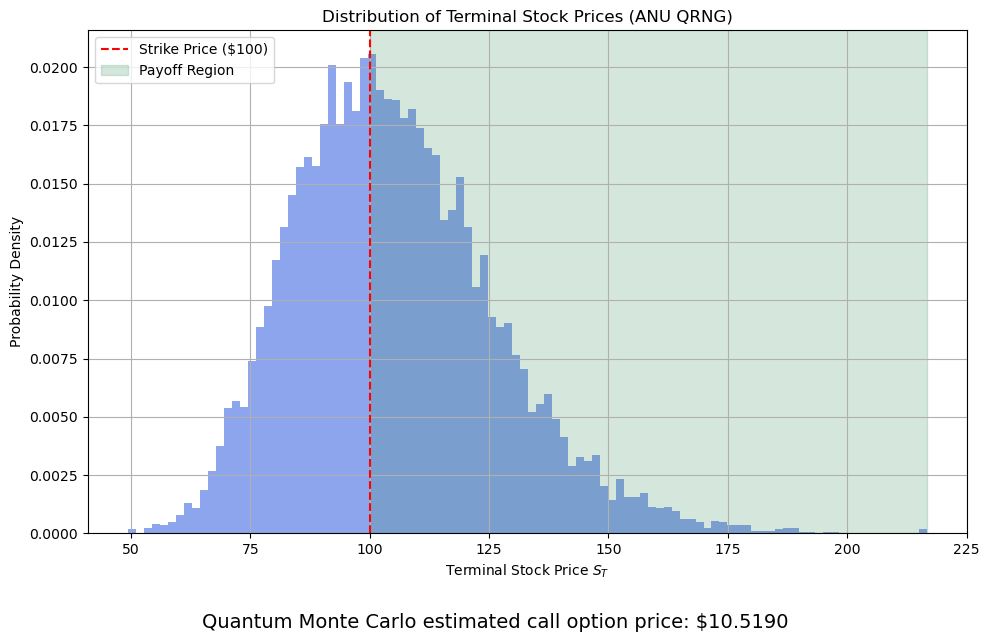

In [10]:
#Run Simulation
print("Fetching quantum random numbers from ANU QRNG API and pricing the option...")
price, ST = monte_carlo_qrng(S0, K, T, r, sigma, N)

#Plot Results
if ST is not None and isinstance(ST, np.ndarray):
    plt.figure(figsize=(10,6))
    plt.hist(ST, bins=100, density=True, alpha=0.6, color='royalblue')
    plt.axvline(K, color='red', linestyle='--', label=f'Strike Price (${K})')
    plt.title('Distribution of Terminal Stock Prices (ANU QRNG)')
    plt.xlabel('Terminal Stock Price $S_T$')
    plt.ylabel('Probability Density')

    plt.figtext(0.5, -0.05, f"\nQuantum Monte Carlo estimated call option price: ${price:.4f}", 
            wrap=True, horizontalalignment='center', fontsize=14)

    #highlight payoff region
    plt.axvspan(K, ST.max(), color='seagreen', alpha=0.2, label='Payoff Region')
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Error: Stock prices (ST) not generated correctly.")

### Limitations: 

- The free tier of ANU QRNG provides 100 requests per calendar month and 1 request per second. Therefore, this code will default to the psuedorandom generator whenever this limit is reached. 

## Resources: 

* https://www.ibm.com/quantum/blog/quantum-markov-chain-monte-carlo
* "Quantum Computing for Everyone" by Chris Bernhardt 2019
* "Six Ideas that Shaped Physics" by Thomas Moore, 4e
* https://quantumnumbers.anu.edu.au/faq


## Next Steps: 
Quantum Amplitude Estimation (Advanced QMC)
- QAE offers quadratic speedup over classical MC. 